In [1]:
from rl_agent import Agent # own implementations
from rl_environment import GridWorld # own implementations
from rl_render import Render # own implementations
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import logging
import warnings
import copy

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, format='%(finame)s - %(lineno)d - %(levelname)s : %(message)s',
                     datefmt='%H:%M:%S')
logger = logging.getLogger('my-logger')
logger.propagate = False
# logger.disabled = True

# ploting settings
plt.rcParams["figure.figsize"] = [5, 5]
plt.rcParams["figure.autolayout"] = True

In [13]:
def init_env(config=0):
    # creating simple grid
    if config==0:
        world = GridWorld(6,6,
                setRewards= {'default': -0.02},
                environmentDynamics='stochastic')
        
        # adding more complexity to the grid (terrains and goals)
        world.addTerminal(('goal',[(0,5),(5,2)]),
                        ('negative_goal',[(2,4)]))
        world.addTerrain(('wall',[(0,2),(1,2),(4,2),(5,0),(5,1)]),
                        ('shortcut', [(1,1),(1,3)]))
    else:
        world = GridWorld(5,5,
                setRewards= {'default': -0.02},
                environmentDynamics='stochastic')
        
        # adding more complexity to the grid (terrains and goals)
        world.addTerminal(('goal',[(4,2)]),
                        ('negative_goal',[(2,4)]))
        world.addTerrain(('wall',[(0,2),(3,2),(4,0),(4,1)]),
                        ('shortcut', [(1,1),(1,3)]))

    return world

# train using value iteration
def value_iteration(agent:Agent, world:GridWorld, render:Render, gamma, theta, ignore_converged_s, episodes):
    for episode in episodes: 
        agent.reset(world)
        _ , iterations = agent.valueIteration(world, max_iterations=episode, gamma=gamma, theta=theta , ignore=ignore_converged_s) 

        agent.policy = agent.prob_to_determin_policy(world, agent.policy, method='greedy')
        render.renderEnv(style='image', results=True,
            title=f'value iteration:\n gamma:{gamma},theta:{theta},ignore:{ignore_converged_s},converged_in={iterations}')
        

# train using MC estimates policy evaluation   
def MC_estimate_policy_evaluation(agent:Agent, world:GridWorld, render:Render, gamma, max_steps_per_iteration, episodes):
    for episode in episodes: # MC estimates policy evaluation
        agent.reset(world)
        agent.policy = agent.policyGenerator(world)
        agent.evaluatePolicyLoop_MC(world, policy=agent.policy, samples=episode , max_steps=max_steps_per_iteration)
        agent.policy = agent.DP_GreedyPolicy(world)
        agent.policy = agent.prob_to_determin_policy(world, agent.policy, method='greedy')
        render.renderEnv(style='color map', results=True,
        title=f'MC estimates on heuristic policy:\n gamma:{gamma},max_stpPerIter:{max_steps_per_iteration},episodes={episode}')

# train using general policy iteration
def policy_iteration(agent:Agent, world:GridWorld, render:Render,episodes, 
                      gamma=0.9, alpha=0.1,epsilon=0.2,s_per_i=200,rtol=0.2,converge_condition='close', 
                      style='color map', method='DP',render_in_grid=True, **kwargs):
    agent.reset(world)
    heuristic_pi = agent.policyGenerator(world)
    for episode in episodes: # policy iteration # TODO: fix policy iteration
        measurments = None
        tracked_Qsa = None
        if method=='MC':
            policy, measurments, tracked_Qsa = agent.MC_policyIteration(world,policy=heuristic_pi, max_iterations=episode,
                                                        gamma=gamma,epsilon=epsilon,
                                                        converge_condition=converge_condition,steps_per_iter=s_per_i ,rtol=rtol, **kwargs)
            iterations = len(measurments['iteration'])
        elif method=='TD':
            policy, measurments, tracked_Qsa = agent.TD_SARSA_policyIteration(world,policy=heuristic_pi, max_iterations=episode,
                                                        gamma=gamma,alpha=alpha,epsilon=epsilon, 
                                                        converge_condition=converge_condition,steps_per_iter=s_per_i ,rtol=rtol, **kwargs)
            iterations = len(measurments['iteration'])
        elif method=='DP':
            policy, iterations = agent.DP_policyIteration(world,policy=heuristic_pi, max_iterations=episode,
                                                        gamma=gamma,epsilon=epsilon,
                                                        converge_condition=converge_condition,steps_per_iter=s_per_i ,rtol=rtol, **kwargs)
        else:
            raise ValueError('please pick a method for the policy iteration algorithem. Options : [ "TD" , "MC" , "DP" ]')

        if render_in_grid: 
            agent.policy = agent.prob_to_determin_policy(world, agent.policy, method='greedy')
            render.renderEnv(style=style, results=True,
                            title=f'policy iteration: {method}\n gamma:{gamma},alpha:{alpha},converged_in={iterations} from max {episode}')

    return measurments , tracked_Qsa

def plot_measurments(measurments:pd.DataFrame, title:str=None):
    episodes_returns = copy.copy(measurments['episode_returns'])
    episode_wall_clock_times = copy.copy(measurments['episode_times'])
    # episode_wall_clock_times *= 1000 # convert to ms

    avr_returns = np.zeros_like(episodes_returns)
    for i in range(len(episodes_returns)):
        avr_returns[i] = np.mean(episodes_returns[:i+1])

    fig, (ax_1,ax_2) = plt.subplots(1,2,sharey=True)
    ax_1.plot(np.arange(1,avr_returns.size + 1) ,avr_returns,label='average return')
    ax_1.set_xlabel('episode')
    # ax_1.legend()

    ax_2.plot(episode_wall_clock_times,avr_returns,label='average return')
    ax_2.set_xlabel('wall clock time (s)')
    # ax_2.legend()

    fig.supylabel('Average return')
    fig.suptitle(title)

    plt.show()

def plot_tracked_Qsa(tracked_Qsa_means:dict, tracked_Qsa_stds:dict, method='TD', title=None):
    fig = plt.figure()
    ax = fig.add_subplot()
    for pair in tracked_Qsa_means.keys():
        Q_values_sa_means = np.array(tracked_Qsa_means[pair])
        Q_values_sa_stds = np.array(tracked_Qsa_stds[pair])
        ax.plot(Q_values_sa_means,label=f'{method} Q{pair} - mean')
        ax.plot(Q_values_sa_stds, linestyle='--',label=f'{method} Q{pair} - std')
        ax.fill_between(np.arange(Q_values_sa_means.size), Q_values_sa_means - Q_values_sa_stds, Q_values_sa_means + Q_values_sa_stds, alpha=0.2)
    ax.set_xlabel('episode')
    ax.legend()
    fig.suptitle(title)
    plt.show()

def avrg_measurments_over_iterations(iterations=10, **kwargs):

    samples_measurments = np.array([policy_iteration(**kwargs) for _ in range(iterations)])
    all_measurments = samples_measurments[:,0]
    
    all_episode_returns = [all_measurments[i]['episode_returns'] for i in range(iterations)]
    episode_returns_means = np.mean(all_episode_returns,axis=0)
    all_episode_wall_clock_times = [all_measurments[i]['episode_times'] for i in range(iterations)]
    episode_wall_clock_times_means = np.mean(all_episode_wall_clock_times,axis=0)
    measurments_means = pd.DataFrame({'episode_returns':episode_returns_means,'episode_times':episode_wall_clock_times_means})

    all_tracked_Qsa = samples_measurments[:,1]
    tracked_Qsa_means = {(sa_pair): np.mean(np.array([Q_sa_dict[sa_pair] for Q_sa_dict in all_tracked_Qsa]),axis=0) for sa_pair in all_tracked_Qsa[0].keys()}
    tracked_Qsa_stds = {(sa_pair): np.std(np.array([Q_sa_dict[sa_pair] for Q_sa_dict in all_tracked_Qsa]),axis=0) for sa_pair in all_tracked_Qsa[0].keys()}

    return measurments_means, tracked_Qsa_means, tracked_Qsa_stds


In [3]:
# variables for training
episodes_list = [50,200,500,1000,10000]
gamma= 0.9
alpha= 0.1
epsilon= 0.2
ignore_converged_s= 0.2 
max_steps_per_iteration= 400 
relativ_tolerance = 1e-3 # the relative accurecy for testing for policy convergence
absolut_tolerance = 1e-8 # the abolute accurecy for testing for policy convergence

# creating an environment
world = init_env(config=0)

# creating an agent in the gridworld
agent = Agent(environment=world)

# creating render object 
render = Render(env=world, agent=agent)

# initiate rendering resources
render.init_rendering_resources(configuration=0)
# render.start()

rl_agent.py - 591 - INFO : ######## ----------- START TD SARSA POLICY ITERATION ------------------##########


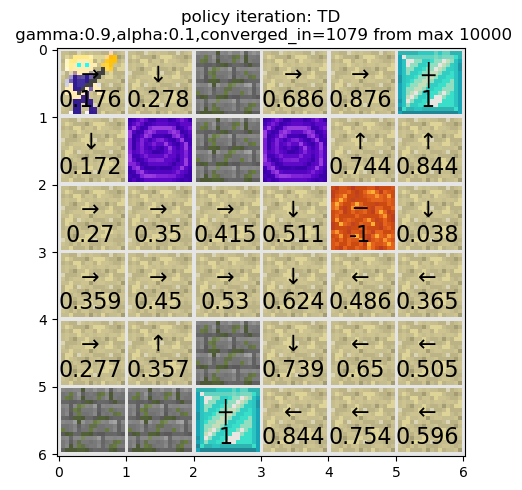

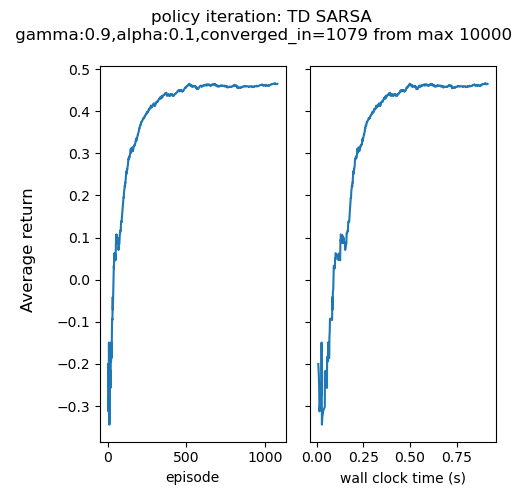

In [4]:
# train the agent using TD policy iteration
episodes_list = [10000]
measurments, tracked_Qsa = policy_iteration(agent,world,render,episodes=episodes_list,
                 gamma=gamma,alpha=alpha,epsilon=epsilon,s_per_i=max_steps_per_iteration,
                 atol=absolut_tolerance, converge_condition='close', style='image', method='TD',)

# render.end()
render.show()
plot_measurments(measurments,title=f'policy iteration: TD SARSA\n gamma:{gamma},alpha:{alpha},converged_in={len(measurments["iteration"])} from max {episodes_list[-1]}')

rl_agent.py - 511 - INFO : ######## ----------- START MC POLICY ITERATION ------------------##########


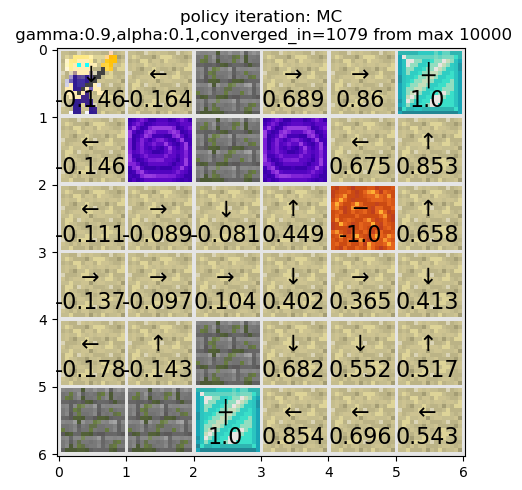

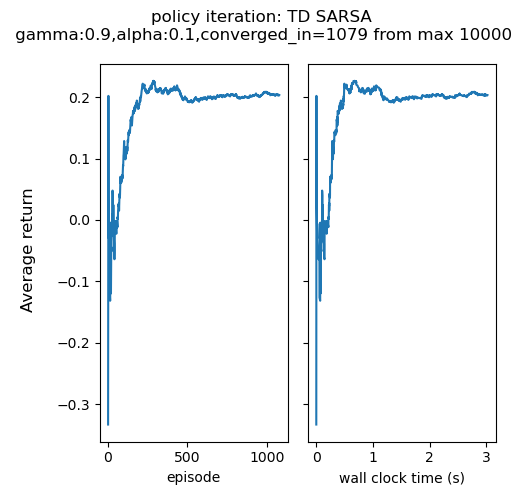

In [5]:
# train the agent using MC policy iteration
measurments, tracked_Qsa = policy_iteration(agent,world,render,episodes=episodes_list,
                 gamma=gamma,alpha=alpha,epsilon=epsilon,s_per_i=max_steps_per_iteration,
                 atol=absolut_tolerance, converge_condition='close', style='image', method='MC',)

# render.end()
render.show()
plot_measurments(measurments,title=f'policy iteration: TD SARSA\n gamma:{gamma},alpha:{alpha},converged_in={len(measurments["iteration"])} from max {episodes_list[-1]}')

In [6]:
episodes_list = [1000]
track_sa_pairs = (((0,0),'L'),((0,1),'L')) # track all these state-action pairs
iterations = 100

state_action_pair = track_sa_pairs[0] # pick a state-action pair for plotting

In [7]:
policy_iteration_kwargs = {'agent':agent,'world':world,'render':render,'episodes':episodes_list,
                 'gamma':gamma,'alpha':alpha,'epsilon':epsilon,'s_per_i':max_steps_per_iteration,
                 'atol':absolut_tolerance,'method':'TD', 'converge_condition':'close','track_sa_pairs':track_sa_pairs,'render_in_grid':False}

TD_measurments_means, TD_tracked_Qsa_means, TD_tracked_Qsa_stds = avrg_measurments_over_iterations(iterations,**policy_iteration_kwargs)


rl_agent.py - 591 - INFO : ######## ----------- START TD SARSA POLICY ITERATION ------------------##########
rl_agent.py - 591 - INFO : ######## ----------- START TD SARSA POLICY ITERATION ------------------##########
rl_agent.py - 591 - INFO : ######## ----------- START TD SARSA POLICY ITERATION ------------------##########
rl_agent.py - 591 - INFO : ######## ----------- START TD SARSA POLICY ITERATION ------------------##########
rl_agent.py - 591 - INFO : ######## ----------- START TD SARSA POLICY ITERATION ------------------##########
rl_agent.py - 591 - INFO : ######## ----------- START TD SARSA POLICY ITERATION ------------------##########
rl_agent.py - 591 - INFO : ######## ----------- START TD SARSA POLICY ITERATION ------------------##########
rl_agent.py - 591 - INFO : ######## ----------- START TD SARSA POLICY ITERATION ------------------##########
rl_agent.py - 591 - INFO : ######## ----------- START TD SARSA POLICY ITERATION ------------------##########
rl_agent.py - 591 -

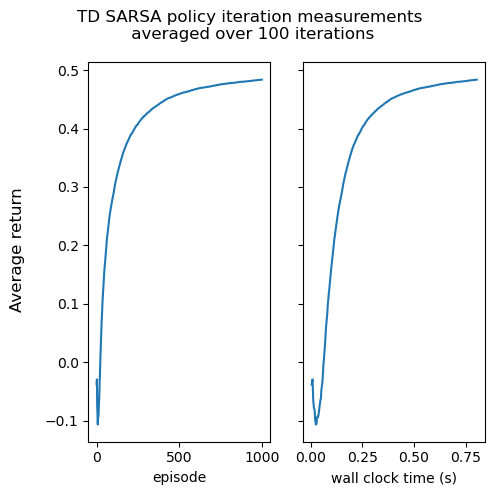

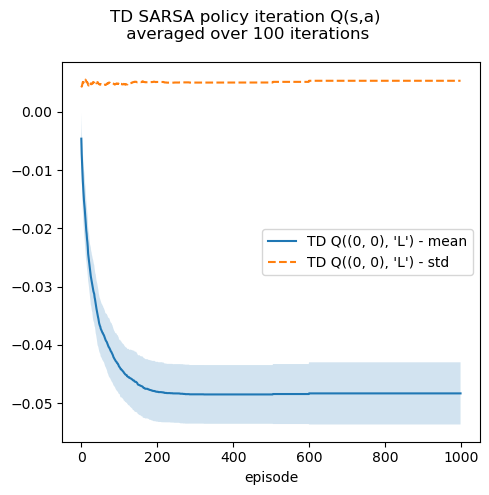

In [8]:
plot_measurments(TD_measurments_means, title=f'TD SARSA policy iteration measurements\n averaged over {iterations} iterations')
# plot_tracked_Qsa(TD_tracked_Qsa_means, TD_tracked_Qsa_stds, method='TD', title='TD SARSA policy iteration Q(s,a)')

TD_means_dict = {state_action_pair: TD_tracked_Qsa_means[state_action_pair]}
TD_stds_dict = {state_action_pair: TD_tracked_Qsa_stds[state_action_pair]}

plot_tracked_Qsa(TD_means_dict, TD_stds_dict, method='TD', title=f'TD SARSA policy iteration Q(s,a)\n averaged over {iterations} iterations')

In [9]:
policy_iteration_kwargs = {'agent':agent,'world':world,'render':render,'episodes':[1000],
                 'gamma':gamma,'alpha':alpha,'epsilon':epsilon,'s_per_i':max_steps_per_iteration,
                 'atol':absolut_tolerance,'method':'MC', 'converge_condition':'close','track_sa_pairs':track_sa_pairs,'render_in_grid':False}

MC_measurments_means, MC_tracked_Qsa_means, MC_tracked_Qsa_stds = avrg_measurments_over_iterations(iterations,**policy_iteration_kwargs)

rl_agent.py - 511 - INFO : ######## ----------- START MC POLICY ITERATION ------------------##########
rl_agent.py - 511 - INFO : ######## ----------- START MC POLICY ITERATION ------------------##########
rl_agent.py - 511 - INFO : ######## ----------- START MC POLICY ITERATION ------------------##########
rl_agent.py - 511 - INFO : ######## ----------- START MC POLICY ITERATION ------------------##########
rl_agent.py - 511 - INFO : ######## ----------- START MC POLICY ITERATION ------------------##########
rl_agent.py - 511 - INFO : ######## ----------- START MC POLICY ITERATION ------------------##########
rl_agent.py - 511 - INFO : ######## ----------- START MC POLICY ITERATION ------------------##########
rl_agent.py - 511 - INFO : ######## ----------- START MC POLICY ITERATION ------------------##########
rl_agent.py - 511 - INFO : ######## ----------- START MC POLICY ITERATION ------------------##########
rl_agent.py - 511 - INFO : ######## ----------- START MC POLICY ITERATION

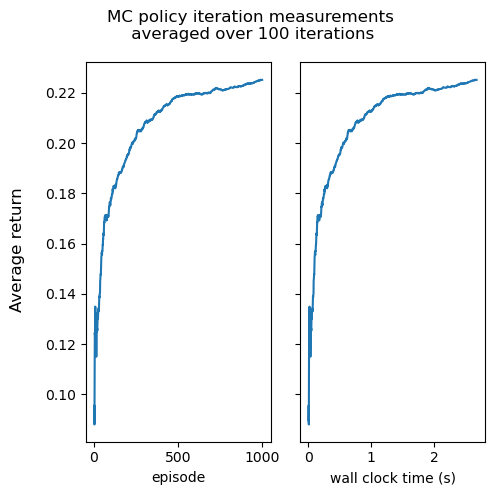

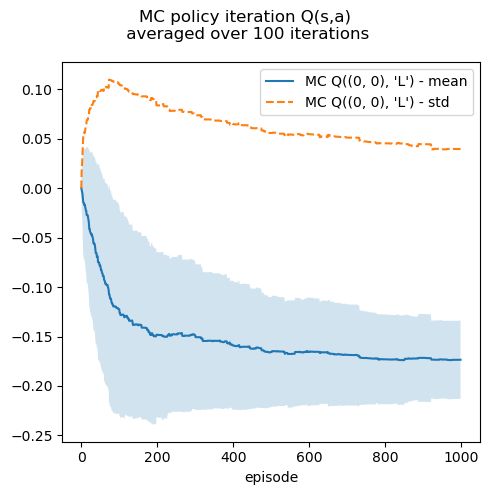

In [14]:
plot_measurments(MC_measurments_means, title=f'MC policy iteration measurements\n averaged over {iterations} iterations')
# plot_tracked_Qsa(MC_tracked_Qsa_means, MC_tracked_Qsa_stds, method='MC', title='MC policy iteration Q(s,a)')

MC_means_dict = {state_action_pair: MC_tracked_Qsa_means[state_action_pair]}
MC_stds_dict = {state_action_pair: MC_tracked_Qsa_stds[state_action_pair]}

plot_tracked_Qsa(MC_means_dict, MC_stds_dict, method='MC', title=f'MC policy iteration Q(s,a)\n averaged over {iterations} iterations')

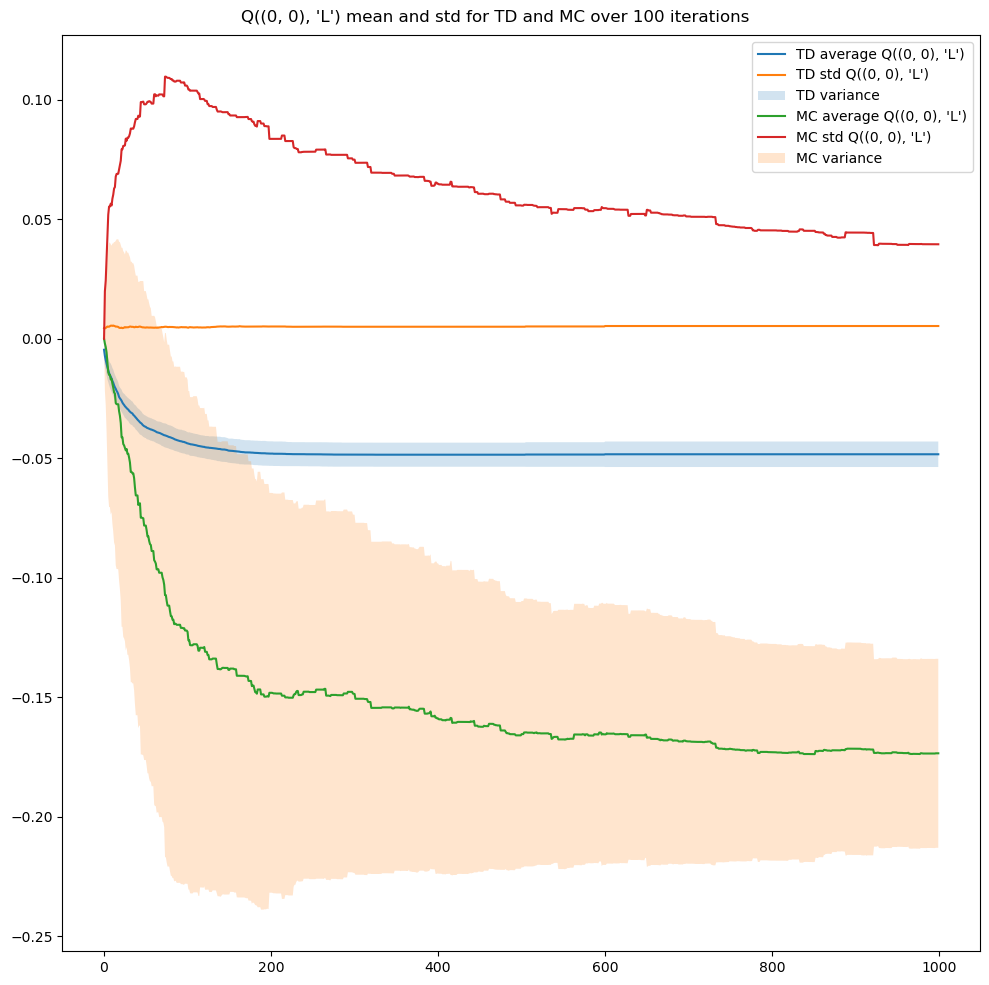

In [15]:
# the plots together for comarisions
TD_means = TD_means_dict[state_action_pair]
TD_stds = TD_stds_dict[state_action_pair]
MC_means = MC_means_dict[state_action_pair]
MC_stds = MC_stds_dict[state_action_pair]

fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle(f'Q{state_action_pair} mean and std for TD and MC over {iterations} iterations')
ax.plot(TD_means, label=f'TD average Q{state_action_pair}')
ax.plot(TD_stds, label=f'TD std Q{state_action_pair}')
ax.fill_between(range(len(TD_means)),TD_means +TD_stds,TD_means-TD_stds,alpha=0.2,label='TD variance')

ax.plot(MC_means, label=f'MC average Q{state_action_pair}')
ax.plot(MC_stds, label=f'MC std Q{state_action_pair}')
ax.fill_between(range(len(MC_means)),MC_means+MC_stds,MC_means-MC_stds,alpha=0.2,label='MC variance')

ax.legend()
plt.show()